# Water Quality Lesson 2: Visualize EMIT and ECOSTRESS Water Quality

**Summary:** In this notebook, we will find EMIT imagery that overlaps with our waterbody of interest, visualize differences in aquatic visible to shortwave infrared spectra, and generate water quality maps. 

**Objectives:**

1) Identify differences in spectra
   
2) Apply water quality algorithm to EMIT image

3) Learn how to interpolate EMIT images to match ECOSTRESS

**Sections of Notebook**
- Part 1: Data Preparation
- Part 2: Visuzalize EMIT Spectra
- Part 3: Apply Water Quality Algorithms

Written By: Kelly Luis, JPL (kelly.m.luis@jpl.nasa.gov)

**Code adapted from the [EMIT Github repo](https://github.com/nasa/EMIT-Data-Resources) and the [VITALS Github repo](https://github.com/nasa/VITALS/). Many thanks to the LP.DAAC team!**

#### TO DO:
1. Adjust Data Path for HYR-SENSE 

## Part 1: Data Preparation

In [1]:
# Load Modules
import pandas as pd
import matplotlib.pyplot as plt # Plotting Function
import numpy as np
import requests
import os
from osgeo import gdal
import earthaccess
from modules.emit_aqua import mask_aqua, rho2Rrs, ndci, ndti
import math
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
import rioxarray as rxr
import geopandas as gp
from modules.spectral_index import normalized_diff
import csv
import xarray as xr
from scipy.stats import linregress
import sys
sys.path.append(os.path.join(os.path.expanduser("~"),"HYR-SENSE","tools","emit","python","modules"))
from emit_tools import emit_xarray
#from modules.emit_tools import emit_xarray # Local
from modules.emit_aqua import mask_aqua, rho2Rrs, ndci, ndti

In [2]:
# Set Variable for Data Store Path
data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/water_quality'
#data_store_path = 'data' #Local 

# Load EMIT File
emit_filename = os.path.join(data_store_path,"EMIT_L2A_RFL_001_20230403T190544_2309313_020.nc")
emit = emit_xarray(emit_filename, ortho=True)
emit['reflectance'].data[:,:,emit['good_wavelengths'].data==0] = np.nan
emit['reflectance'].data[emit['reflectance'].data == -9999] = np.nan

In [3]:
# Crop for Neenoshe Reservoir via Bounding Box 
N = 38.362006
W = -102.720106
S = 38.314948
E = -102.654359

emit_ds = emit.sel(longitude=slice(W, E), latitude=slice(N, S))

In [4]:
# Visualize EMIT RGB  
emit_rgb = emit_ds.sel(wavelengths=[650, 560, 470], method='nearest')

# RGB Plotting Funciton
def gamma_adjust(rgb_ds, bright=0.2, white_background=False):
    array = rgb_ds.reflectance.data
    gamma = math.log(bright)/math.log(np.nanmean(array)) # Create exponent for gamma scaling - can be adjusted by changing 0.2 
    scaled = np.power(np.nan_to_num(array,nan=1),np.nan_to_num(gamma,nan=1)).clip(0,1) # Apply scaling and clip to 0-1 range
    if white_background == True:
        scaled = np.nan_to_num(scaled, nan = 1) # Assign NA's to 1 so they appear white in plots
    rgb_ds.reflectance.data = scaled
    return rgb_ds

emit_rgb = gamma_adjust(emit_rgb,white_background=True)
map = emit_rgb.hvplot.rgb(fontscale=1.5, xlabel='Longitude',ylabel='Latitude',frame_width=480, frame_height=480)
map

:RGB   [longitude,latitude]   (R,G,B)

In [5]:
# Load ECOSTRESS 
eco_filename = os.path.join(data_store_path, "ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_LST.tif")
eco_lst_ds = rxr.open_rasterio(eco_filename).squeeze('band', drop=True)
eco_lst_ds

<xarray.DataArray (y: 1568, x: 1568)> Size: 10MB
[2458624 values with dtype=float32]
Coordinates:
  * x            (x) float64 13kB 7e+05 7.001e+05 ... 8.096e+05 8.097e+05
  * y            (y) float64 13kB 4.3e+06 4.3e+06 4.3e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
# Visualize Shapefile
colorado_file = os.path.join(data_store_path,"co_lr/co_lr.shp")
gdf = gp.read_file(colorado_file)
polygon = gdf[gdf['NAME'] == 'Neenoshe Reservoir']
polygon.hvplot(tiles='ESRI', color='#d95f02',alpha=0.6, crs='EPSG:4326', frame_height=405, frame_width=720, fontscale=2) 

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [9]:
# ECOSTRESS Visualization
size_opts = dict(frame_height=405, frame_width=720, fontscale=2)
eco_ds = eco_lst_ds.rio.reproject("EPSG:4326")
eco_ds = eco_ds.sel(x=slice(W, E), y=slice(N,S))
eco_ds = eco_ds.rename({'x': 'longitude','y': 'latitude'})
eco_ds.hvplot.image(x='longitude', y='latitude', **size_opts, 
                    cmap='inferno', tiles='ESRI', xlabel='Longitude', 
                    ylabel='Latitude', title='ECOSTRESS LST (K)', 
                    crs='EPSG:4326')*polygon.hvplot(color='Red',alpha=0.5, crs='EPSG:4326')   

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Image.I    :Image   [longitude,latitude]   (value)
   .Polygons.I :Polygons   [Longitude,Latitude]

## Part 2: Visualize EMIT Spectra

In [10]:
# Interactive Points Plotting
# Modified from https://github.com/auspatious/hyperspectral-notebooks/blob/main/03_EMIT_Interactive_Points.ipynb
POINT_LIMIT = 5
color_cycle = hv.Cycle('Category20')

# Create RGB Map
map = emit_rgb.hvplot.rgb(fontscale=1.5, xlabel='Longitude',ylabel='Latitude',frame_width=480, frame_height=480)

# Set up a holoviews points array to enable plotting of the clicked points
xmid = emit_ds.longitude.values[int(len(emit_ds.longitude) / 2)]
ymid = emit_ds.latitude.values[int(len(emit_ds.latitude) / 2)]

first_point = ([xmid], [ymid], [0])
points = hv.Points(first_point, vdims='id')
points_stream = hv.streams.PointDraw(
    data=points.columns(),
    source=points,
    drag=True,
    num_objects=POINT_LIMIT,
    styles={'fill_color': color_cycle.values[1:POINT_LIMIT+1], 'line_color': 'gray'}
)

posxy = hv.streams.PointerXY(source=map, x=xmid, y=ymid)
clickxy = hv.streams.Tap(source=map, x=xmid, y=ymid)

# Function to build spectral plot of clicked location to show on hover stream plot
def click_spectra(data):
    coordinates = []
    if data is None or not any(len(d) for d in data.values()):
        coordinates.append(clicked_points[0][0], clicked_points[1][0])
    else:
        coordinates = [c for c in zip(data['x'], data['y'])]
    
    plots = []
    for i, coords in enumerate(coordinates):
        x, y = coords
        data = emit_ds.sel(longitude=x, latitude=y, method="nearest")
        plots.append(
            data.hvplot.line(
                y="reflectance",
                x="wavelengths",
                color=color_cycle,
                label=f"{i}"
            )
        )
        points_stream.data["id"][i] = i
    return hv.Overlay(plots)

def hover_spectra(x,y):
    return emit_ds.sel(longitude=x,latitude=y,method='nearest').hvplot.line(y='reflectance',x='wavelengths',
                                                                            color='black', frame_width=400)
# Define the Dynamic Maps
click_dmap = hv.DynamicMap(click_spectra, streams=[points_stream])

hover_dmap = hv.DynamicMap(hover_spectra, streams=[posxy])

# Plot the Map and Dynamic Map side by side
hv.Layout(hover_dmap*click_dmap + map * points).cols(2).opts(
    hv.opts.Points(active_tools=['point_draw'], size=10, tools=['hover'], color='white', line_color='gray'),
    hv.opts.Overlay(show_legend=False, show_title=False, fontscale=1.5, frame_height=480)
)

:Layout
   .DynamicMap.I :DynamicMap   []
      :Overlay
         .Curve.I   :Curve   [wavelengths]   (reflectance)
         .Curve.A_0 :Curve   [wavelengths]   (reflectance)
   .Overlay.I    :Overlay
      .RGB.I    :RGB   [longitude,latitude]   (R,G,B)
      .Points.I :Points   [x,y]   (id)

In [12]:
# Save Spectra to CSV
data = points_stream.data
wavelengths = emit_ds.wavelengths.values

rows = [["id", "x", "y"] + [str(i) for i in wavelengths]]
 
for p in zip(data['x'], data['y'], data['id']):
    x, y, i = p
    spectra = emit_ds.sel(longitude=x, latitude=y, method="nearest").reflectance.values
    row = [i, x, y] + list(spectra)
    rows.append(row)

with open('data/emit_click_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(rows)

## Part 2: Apply Water Quality Algorithms

We will apply two spectral indices: Normalized Difference Turbidity Index and Normalized Difference Chlorophyll Index.

### Normalized Difference Chlorophyll Index from Mishra and Mishra, 2012
$$ NDCI=\frac{(R_{rs}(708) - R_{rs}(665))}{(R_{rs}(708) + R_{rs}(665)} $$    
$$ R_{rs}=Remote \ sensing \ reflectance $$

### Normalized Difference Turbidity Index from Lacaux et al. 2007
$$ NDTI=\frac{(\rho_{Red} - \rho_{Green})}{(\rho_{Red} + \rho_{Green}} $$    
$$ \rho = surface \ reflectance $$   


In [13]:
# Pre-processing
ds_aqua = mask_aqua(emit_ds) # Cloud and Land Mask
ds_aqua['Rrs'] = rho2Rrs(ds_aqua) # Calculate Remote Sensing Reflectance
ds_aqua['NDCI'] = ndci(ds_aqua)
ds_aqua

<xarray.Dataset> Size: 25MB
Dimensions:           (latitude: 87, longitude: 122, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB ...
    good_wavelengths  (wavelengths) float32 1kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
  * latitude          (latitude) float64 696B 38.36 38.36 38.36 ... 38.32 38.32
  * longitude         (longitude) float64 976B -102.7 -102.7 ... -102.7 -102.7
    elev              (latitude, longitude) float32 42kB 1.181e+03 ... 1.169e+03
    spatial_ref       int64 8B 0
    cirrus_mask       (latitude, longitude) int64 85kB 0 0 0 0 0 0 ... 0 0 0 0 0
    land_mask         (latitude, longitude) int64 85kB 0 0 0 0 0 0 ... 0 0 0 0 0
    cloud_mask        (latitude, longitude) int64 85kB 0 0 0 0 0 0 ... 0 0 0 0 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 12MB 0.04834...
    Rrs               (latitude, longitude, wavelengths) float32 12MB 0.01539...
    NDCI              (latitude, longitude) float32 42kB 0.04259 ... 0.04818
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.03613320e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20230403T190544_23093...
    Orthorectified:                    True

In [14]:
# Normalized Difference Turbidity Index
red = ds_aqua.Rrs.sel(wavelengths=665, method='nearest')
nir = ds_aqua.Rrs.sel(wavelengths=708, method='nearest')
ds_aqua['NDCI'] = (nir - red)/(nir + red)
ds_aqua['NDCI'].where(ds_aqua.land_mask==1).hvplot(x='longitude', y='latitude', aspect = 'equal', frame_width=400, cmap='Viridis')

:Image   [longitude,latitude]   (NDCI)

In [15]:
# Normalized Difference Turbidity Index
green = ds_aqua.Rrs.sel(wavelengths=561, method='nearest')
red = ds_aqua.Rrs.sel(wavelengths=655, method='nearest')
ds_aqua['NDTI'] = (red - green)/(red + green)
ds_aqua['NDTI'].where(ds_aqua.land_mask==1).hvplot(x='longitude', y='latitude', aspect = 'equal', frame_width=400, cmap='Viridis')

:Image   [longitude,latitude]   (NDTI)

<div class="alert alert-block alert-info">
<b> Exercises </b>

1. You can vary the colorbar range by adjusting *clim* values (20-50). When you adjust the ranges, what are the differences that occur between the two waterbodies? 

2. What aquatic processes could contribute to the large chlorophyll range (e.g., phytoplankton bloom, other types of aquatic biomass present?)

3. Try out different algorithms and water qualtiy products! Across algorithms, what differences are you observing? What algorithms seem like a reasonable range?

</div>

## Part 3: Compare ECOSTRESS and EMIT

The spatial resolution of EMIT is 60x60m while the ECOSTRESS resolution is 70x70m. We need to coarsen the EMIT pixels to match the ECOSTRESS spatial resolution. Xarray has a very handy function (interp_like) to do this calculation very quickly. 

In [16]:
# Coasrsen EMIT like ECOSTRESS
emit_coarse = ds_aqua.interp_like(eco_ds)

In [17]:
# Quick Visualization of EMIT Coarsened to ECOSTRESS resolution
emit_coarse['NDCI'].where(emit_coarse.land_mask==1).hvplot(x='longitude', y='latitude', aspect = 'equal', frame_width=400, cmap='Viridis')

:Image   [longitude,latitude]   (NDCI)

In [18]:
# Quick Visualization of ECOSTRESS with EMIT's land mask
eco_ds.where(emit_coarse.land_mask == 1).hvplot(x='longitude', y='latitude', aspect = 'equal', frame_width=400, cmap='Magma')

:Image   [longitude,latitude]   (value)

In [19]:
# Quick and Dirty Regression 
x = emit_coarse.NDTI.where(emit_coarse.land_mask == 1).values.flatten()
y = eco_ds.where(emit_coarse.land_mask == 1).values.flatten()
df = pd.DataFrame(data={'x':x, 'y':y}).dropna()
slope, intercept, r, p, se = linregress(df.x.values, df.y.values)

Text(0.5, 1.0, 'EMIT NDCI vs. ECOSTRESS LST')

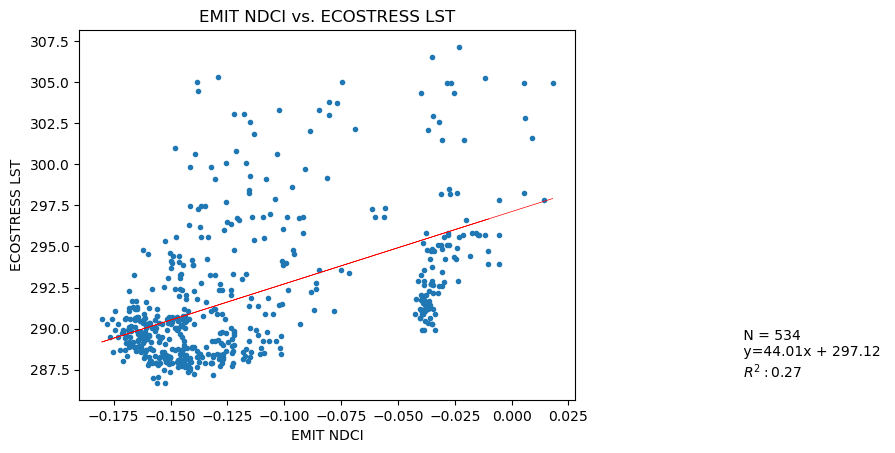

In [20]:
# Visualize Regression
fig,ax = plt.subplots(1,1)
ax.plot(x.flatten(), y.flatten(), '.')
ax.plot(df.x.values, intercept + slope * df.x.values, 'r', linewidth=.5)
ax.set_xlabel('EMIT NDCI')
ax.set_ylabel('ECOSTRESS LST')
ax.text(0.1, 287,  f" N = {str(len(df.x))} {chr(10)} y={np.round(slope, 2)}x + {np.round(intercept, 2)} {chr(10)} $R^2:{np.round(r ** 2, 2)}$")
ax.set_title('EMIT NDCI vs. ECOSTRESS LST')

<div class="alert alert-block alert-info">
<b> Exercises </b>

1. Try out different bands in the spectral indices. How does it change the spatial patterns in the lake?

2. What aquatic processes could contribute to the differences between chlorophyll and temperature in the regression plot (e.g., phytoplankton bloom, other types of aquatic biomass present)?

3. Replace the filenames with the Niwot Ridge EMIT (EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc) and and ECOSTRESS (data/iplant/home/shared/esiil/HYR_SENSE/data/water_quality/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_LST.tif) scenes uploaded in the data-store. Modify the code to make it work! You got this! 
 
</div>

## Additional Resources

- [CSIRO EMIT Exploration Code](https://github.com/auspatious/hyperspectral-notebooks/blob/main): Water Extraction and Exploration code 
- [HyperCoast](https://github.com/opengeos/HyperCoast): EMIT and PACE visualization and algorithm toolbox in Python
- [Digital Earth Africa](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Real_world_examples/index.html): Digital Earth Africa has several notebook tutorials with Landsat based spectral indices
- [NEON Tutorials](https://www.neonscience.org/resources/learning-hub/tutorials): Search for "hyperspectral" in the keyword box and you will find lots of great resources!

## References

- Lacaux et al (2007), Classification of ponds from high-spatial resolution remote sensing: Application to Rift Valley Fever epidemics in Senegal, Remote Sensing of Environment, 106, 66-74.
- Mishra & Mishra (2012). Normalized difference chlorophyll index: A novel model for remote estimation of chlorophyll-a concentration in turbid productive waters. Remote Sensing of Environment, 117, 394-406. 
